This file is used to run the different ML models for the segmented analysis dataset, some manual customization is required

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import geopy.distance
import os
import math
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from subprocess import call

In [2]:
full_set = pd.read_csv('Data/full_set_SDA.csv', header=0)

# RandomForest Classifier:
Choose the iteration you would like to perform by commenting out the different iterations

In [ ]:
# Determine the best fitting max_depth parameter to combat overfitting

# Iteration 1:
# full_x = full_set[['speed']]
# Iteration 2:
# full_x = full_set[['speed', 'speed_lead_1']]
# Iteration 3:
# full_x = full_set[['speed', 'speed_lead_1', 'bearing change']]
# Iteration 4:
full_x = full_set[['speed', 'speed_lead_1', 'bearing change', 'distance to port']]

full_y = full_set['fishing']

X_train, X_test, y_train, y_test = train_test_split(full_x, full_y, random_state=899370109, test_size=0.3, stratify=full_y)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 51, 4)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = RandomForestClassifier(max_depth=i, criterion='gini', n_estimators=100)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = balanced_accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = balanced_accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.ylabel('Balanced accuracy score')
plt.xlabel('Max_depth value')
plt.title('Balanced accuracy scores per max_depth for SDA Iteration 4')
plt.legend()
plt.show()

true negative:  0.9872448979591837
false negative:  0.16363636363636364
true positive:  0.8363636363636363
false positive:  0.012755102040816327
Precision:  0.9849784235538319
Recall:  0.8363636363636363
F1 score:  0.904607821004841
Accuracy:  0.9118042671614099
Balanced accuracy:  0.9118042671614099


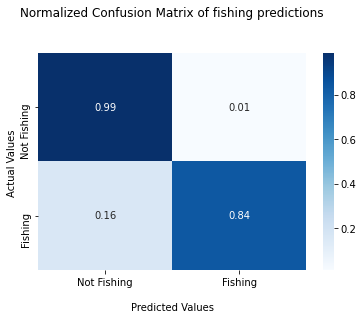

In [3]:
# Run the RFC model, manually insert the optimal hyperparamaters (can be found in paper "Exploring fishing vessel activity classification using machine learning - M. Ros 2022")

# Iteration 1:
# full_x = full_set[['speed']]
# Iteration 2:
# full_x = full_set[['speed', 'speed_lead_1']]
# Iteration 3:
# full_x = full_set[['speed', 'speed_lead_1', 'bearing change']]
# Iteration 4:
full_x = full_set[['speed', 'speed_lead_1', 'bearing change', 'distance to port']]

full_y = full_set['fishing']

# Make train-test split
X_train, X_test, y_train, y_test = train_test_split(full_x, full_y, random_state=899370109, test_size=0.3, stratify=full_y)

# Fit model and predict y-value
clf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion='gini').fit(X_train, y_train)
y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)

# Create confusion matrix, also normalized
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

tn, fp, fn, tp = cmn.ravel()
print('true negative: ', tn)
print('false negative: ', fn)
print('true positive: ', tp)
print('false positive: ', fp)
Precision = (tp/(tp+fp))
Recall = (tp/(tp+fn)) # Is also sensitivity
Specificity = (tn/(tn+fp))
Accuracy = ((tp+tn)/(tp+fp+tn+fn))
F1 = ((2*Precision*Recall)/(Precision+Recall))
bal_accuracy = (Recall + Specificity)/2
print('Precision: ', Precision)
print('Recall: ', Recall)
print('F1 score: ', F1)
print('Accuracy: ', Accuracy)
print('Balanced accuracy: ', bal_accuracy)

ax = sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Normalized Confusion Matrix of fishing predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels
ax.xaxis.set_ticklabels(['Not Fishing','Fishing'])
ax.yaxis.set_ticklabels(['Not Fishing','Fishing'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [10]:
# Export a single decision tree
estimator = clf.estimators_[1]
export_graphviz(estimator, out_file='tree.dot', feature_names=full_x.columns, class_names=['Not Fishing', 'Fishing'], precision=2, filled=True)

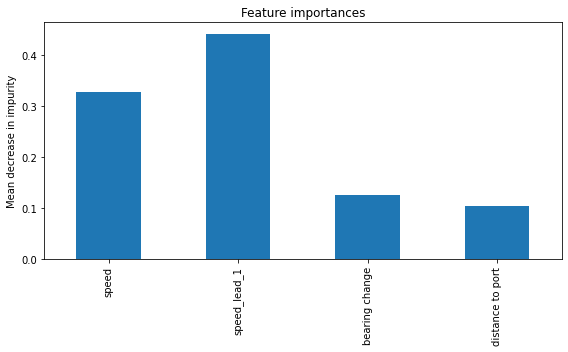

In [13]:
# Investigated feature importance. Use iteration 4 in previous steps.

# Determine feature importance
importances = clf.feature_importances_
feature_names = ['speed', 'speed_lead_1', 'bearing change', 'distance to port']

forest_importances = pd.Series(importances, index=feature_names)

# Plot feature importance
plt.figure(figsize=(8,5))
forest_importances.plot.bar()
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()
plt.savefig('Data\FP_All.png')

# Naïve Bayes

true negative:  0.9770408163265306
false negative:  0.4
true positive:  0.6
false positive:  0.02295918367346939
Precision:  0.9631449631449631
Recall:  0.6
F1 score:  0.739390128890286
Accuracy:  0.7885204081632653
Balanced accuracy:  0.7885204081632653


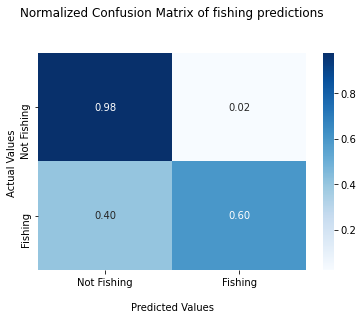

In [4]:
# Run the Naïve Bayes model, manually insert the optimal hyperparamaters (can be found in paper "Exploring fishing vessel activity classification using machine learning - M. Ros 2022")

# Iteration 1:
# full_x = full_set[['speed']]
# Iteration 2:
# full_x = full_set[['speed', 'speed_lead_1']]
# Iteration 3:
# full_x = full_set[['speed', 'speed_lead_1', 'bearing change']]
# Iteration 4:
full_x = full_set[['speed', 'speed_lead_1', 'bearing change', 'distance to port']]

full_y = full_set['fishing']


# Crude undersampler
# # ----------------------------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(full_x, full_y, random_state=899370109, test_size=0.3, stratify= full_y)

rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
# ----------------------------------------------------------------------------------------------------------------

# Fit model and predict y-value
clf = GaussianNB().fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)

# Create confusion matrix also normalized
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create confusion matrix visual
tn, fp, fn, tp = cmn.ravel()
print('true negative: ', tn)
print('false negative: ', fn)
print('true positive: ', tp)
print('false positive: ', fp)
Precision = (tp/(tp+fp))
Recall = (tp/(tp+fn)) # Is also sensitivity
Specificity = (tn/(tn+fp))
Accuracy = ((tp+tn)/(tp+fp+tn+fn))
F1 = ((2*Precision*Recall)/(Precision+Recall))
bal_accuracy = (Recall + Specificity)/2
print('Precision: ', Precision)
print('Recall: ', Recall)
print('F1 score: ', F1)
print('Accuracy: ', Accuracy)
print('Balanced accuracy: ', bal_accuracy)

ax = sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Normalized Confusion Matrix of fishing predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels
ax.xaxis.set_ticklabels(['Not Fishing','Fishing'])
ax.yaxis.set_ticklabels(['Not Fishing','Fishing'])

## Display the visualization of the Confusion Matrix.
plt.show()

# SVM

true negative:  388
false negative:  45
true positive:  10
false positive:  4
Precision:  0.7142857142857143
Recall:  0.18181818181818182
F1 score:  0.2898550724637682
Accuracy:  0.8903803131991052
Balanced accuracy:  0.5858070500927643


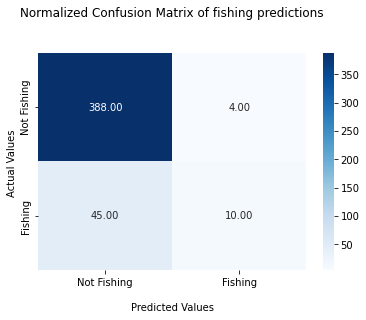

In [37]:
# Run the SVM model, manually insert the optimal hyperparamaters (can be found in paper "Exploring fishing vessel activity classification using machine learning - M. Ros 2022")

# Iteration 1:
# full_x = full_set[['speed']]
# Iteration 2:
# full_x = full_set[['speed', 'speed_lead_1']]
# Iteration 3:
# full_x = full_set[['speed', 'speed_lead_1', 'bearing change']]
# Iteration 4:
full_x = full_set[['speed', 'speed_lead_1', 'bearing change', 'distance to port']]


# Crude undersampler
# ----------------------------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(full_x, full_y, random_state=899370109, test_size=0.3, stratify=full_y)

rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
# ----------------------------------------------------------------------------------------------------------------

# Fit model and predict y-value
clf = SVC(kernel='poly').fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)

# Create confusion matrix also normalized
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create confusion matrix visual
tn, fp, fn, tp = cmn.ravel()
print('true negative: ', tn)
print('false negative: ', fn)
print('true positive: ', tp)
print('false positive: ', fp)
Precision = (tp/(tp+fp))
Recall = (tp/(tp+fn)) # Is also sensitivity
Specificity = (tn/(tn+fp))
Accuracy = ((tp+tn)/(tp+fp+tn+fn))
F1 = ((2*Precision*Recall)/(Precision+Recall))
bal_accuracy = (Recall + Specificity)/2
print('Precision: ', Precision)
print('Recall: ', Recall)
print('F1 score: ', F1)
print('Accuracy: ', Accuracy)
print('Balanced accuracy: ', bal_accuracy)

ax = sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Normalized Confusion Matrix of fishing predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels
ax.xaxis.set_ticklabels(['Not Fishing','Fishing'])
ax.yaxis.set_ticklabels(['Not Fishing','Fishing'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Oman #
To validate the model, the Oman dataset is used to make classifications

In [5]:
# Load the Oman dataset
oman_1 = pd.read_csv("Data/Oman_AIS/raw_ais_20210501_20220531_461000002.txt", sep="\t", header=0)
oman_1['Timestamp'] = pd.to_datetime(oman_1['Timestamp'])
oman_1 = oman_1[['Timestamp', 'Latitude', 'Longitude']]
oman_1 = oman_1.sort_values(by='Timestamp', ignore_index=True)
oman_1 = oman_1.set_index('Timestamp').rename_axis(None)
oman_1.columns = ['LogLatitude', 'LogLongitude']
oman_1 = oman_1.dropna()

In [6]:
# Load additional library
import geopy.distance

# Import worldports dataset
world_ports = pd.read_csv("Data\\wld_trs_ports_wfp.csv", header=0)
world_ports_lim = world_ports[['portname', 'latitude', 'longitude']]

coords_test = tuple(zip(world_ports_lim['latitude'], world_ports_lim['longitude']))

world_ports_lim['coordinates'] = coords_test

array_world_ports_lim = np.array(world_ports_lim['coordinates'].tolist())

# Create distance calculation functions
def find_nearest(lat, long):
    distance_to_port = world_ports_lim.apply(lambda row: geopy.distance.distance((lat, long), (row['latitude'], row['longitude'])).km, axis=1)
    return geopy.distance.distance((lat, long), (world_ports_lim.loc[distance_to_port.idxmin(), 'latitude'], world_ports_lim.loc[distance_to_port.idxmin(), 'longitude'])).km

def broadcasting_based_lng_lat(data1, data2):
    # data1, data2 are the data arrays with 2 cols and they hold
    # lat., lng. values in those cols respectively
    data1 = np.deg2rad(data1)                     
    data2 = np.deg2rad(data2)                     

    lat1 = data1[:,0]                     
    lng1 = data1[:,1]         

    lat2 = data2[:,0]                     
    lng2 = data2[:,1]         

    diff_lat = lat1[:,None] - lat2
    diff_lng = lng1[:,None] - lng2
    d = np.sin(diff_lat/2)**2 + np.cos(lat1[:,None])*np.cos(lat2) * np.sin(diff_lng/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(d))

C:\Users\Admin\AppData\Local\Temp\ipykernel_20412\4171823020.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_ports_lim['coordinates'] = coords_test


In [10]:
# Perform the same feature engineering on the Oman set as has been done for the segmented analysis dataset

full = oman_1
distances = [0]
durations = [0]
index = full.index
i=0
while i < full.shape[0] - 1:
        # print(str(index[i]) + str(full['LogLatitude'][i]) + str(full['LogLongitude'][i]))
        distances.append(geopy.distance.distance((full['LogLatitude'][i], full['LogLongitude'][i]), (full['LogLatitude'][i+1], full['LogLongitude'][i+1])).km)
        durations.append((index[i+1] - index[i]).total_seconds())
        i += 1

km_s = [0]
j=1
while j < len(distances):
        if durations[j] != 0:
                km_s.append((distances[j]/durations[j]) * 60 * 60)
        else:
                km_s.append(0)
        j += 1

full['speed'] = km_s
# -----------------------------------------------------------------------------------------------------------------------------


# Calculate speeds based on lag/lead
# -----------------------------------------------------------------------------------------------------------------------------
speed_lag_1 = []
speed_lead_1 = []
speed_both_1 = []
speed_lag_2 = []
speed_lead_2 = []
speed_both_2 = []

full['lag_1'] = full['speed'].shift(1)
full['lag_2'] = full['speed'].shift(2)
full['lead_1'] = full['speed'].shift(-1)
full['lead_2'] = full['speed'].shift(-2)

m = 0
while m < full.shape[0]:
        speed_current = full['speed'][m]
        lag_1 = full['lag_1'][m]
        lag_2 = full['lag_2'][m]
        lead_1 = full['lead_1'][m]
        lead_2 = full['lead_2'][m]

        if math.isnan(lag_1):
                average_speed_lg1 = speed_current
        else:
                average_speed_lg1 = (speed_current + lag_1) / 2
        
        if math.isnan(lag_2) and math.isnan(lag_1):
                average_speed_lg2 = speed_current
        elif math.isnan(lag_2) and not math.isnan(lag_1):
                average_speed_lg2 = (speed_current + lag_1) / 2
        else:
                average_speed_lg2 = (speed_current + lag_1 + lag_2) / 3
        
        if math.isnan(lead_1):
                average_speed_ld1 = speed_current
        else:
                average_speed_ld1 = (speed_current + lead_1) / 2
        
        if math.isnan(lead_2) and math.isnan(lead_1):
                average_speed_ld2 = speed_current
        elif math.isnan(lead_2) and not math.isnan(lead_1):
                average_speed_ld2 = (speed_current + lead_1) / 2
        else:
                average_speed_ld2 = (speed_current + lead_1 + lead_2) / 3
        
        if math.isnan(lead_1):
                average_speed_b1 = (speed_current + lag_1) / 2
        elif math.isnan(lag_1):
                average_speed_b1 = (speed_current + lead_1) / 2
        else:
                average_speed_b1 = (speed_current + lead_1 + lag_1) / 3
        
        if math.isnan(lead_1):
                average_speed_b2 = (speed_current + lag_1 + lag_2) / 3
        elif math.isnan(lead_2):
                average_speed_b2 = (speed_current + lag_1 + lag_2 + lead_1) / 4
        elif math.isnan(lag_1):
                average_speed_b2 = (speed_current + lead_1 + lead_2) / 3
        elif math.isnan(lag_2):
                average_speed_b2 = (speed_current + lead_1 + lead_2 + lag_1) / 4
        else:
                average_speed_b2 = (speed_current + lead_1 + lag_1 + lead_2 + lag_2) / 5

        speed_lag_1.append(average_speed_lg1)
        speed_lag_2.append(average_speed_lg2)
        speed_lead_1.append(average_speed_ld1)
        speed_lead_2.append(average_speed_ld2)
        speed_both_1.append(average_speed_b1)
        speed_both_2.append(average_speed_b2)
        
        m += 1

full['speed_lag_1'] = speed_lag_1
full['speed_lag_2'] = speed_lag_2
full['speed_lead_1'] = speed_lead_1
full['speed_lead_2'] = speed_lead_2
full['speed_both_1'] = speed_both_1
full['speed_both_2'] = speed_both_2
# -----------------------------------------------------------------------------------------------------------------------------


# Calculate direction based on previous and next
# -----------------------------------------------------------------------------------------------------------------------------
# Create lag and lead of lat/long
full['lat_f1'] = full['LogLatitude'].shift(-1) # latitude with lead 1
full['lon_f1'] = full['LogLongitude'].shift(-1) # Longtitude with lead 1
full['lat_b1'] = full['LogLatitude'].shift(1) # latitude with lag 1
full['lon_b1'] = full['LogLongitude'].shift(1) # Longtitude with lag 1

direction = [0]
geo_track = 1
while geo_track < full.shape[0]:
        delta_lon = full['LogLongitude'][geo_track] - full['lon_b1'][geo_track]
        y2 = math.sin(delta_lon) * math.cos(full['LogLatitude'][geo_track])
        x2 = math.cos(full['lat_b1'][geo_track]) * math.sin(full['LogLatitude'][geo_track]) - math.sin(full['lat_b1'][geo_track]) * math.cos(full['LogLatitude'][geo_track]) * math.cos(delta_lon)

        brng2 = math.atan2(y2, x2)
        brng2 = math.degrees(brng2)

        direction.append(brng2)

        geo_track += 1

full['bearing'] = direction

direction_change = [0, 0]
geo_track2 = 2
while geo_track2 < full.shape[0]:
        change = full['bearing'][geo_track2 - 1] - full['bearing'][geo_track2]
        direction_change.append(change)

        geo_track2 += 1

cur_loc = 0
port_distances = []

while cur_loc < full.shape[0]:
        cord = np.array([(full['LogLatitude'][cur_loc], full['LogLongitude'][cur_loc])])
        p_dist = broadcasting_based_lng_lat(cord, array_world_ports_lim)
        port_distances.append(p_dist.min())

        cur_loc += 1

full['distance to port'] = port_distances

full['bearing change'] = direction_change

entry = 0
index = full.index
window_start = index[0]
window_end = index[0] + timedelta(minutes=35)
window_IDN = 0
window_IDNs = []
window_IDNs2 = []
window_pos = []
all_windows = []

while entry < full.shape[0]:
        if index[entry] >= window_start and index[entry] < window_end:
                window_IDNs.append(window_IDN)
                position = [full['LogLongitude'][entry], full['LogLatitude'][entry], 1.0]
                window_pos.append(position)
        else:
                while index[entry] > window_end:
                        if len(window_pos) > 0:
                                all_windows.append(window_pos)
                                window_IDNs2.append(window_IDN)
                        window_start = window_end
                        window_end = window_start + timedelta(minutes=60)
                        window_IDN += 1
                        window_pos = []
                window_IDNs.append(window_IDN)
                position = [full['LogLongitude'][entry], full['LogLatitude'][entry], 1.0]
                window_pos.append(position)
        entry += 1
        all_windows.append(window_pos)
        window_IDNs2.append(window_IDN)

full['window_IDN'] = window_IDNs

avg_speed = full.groupby('window_IDN')['speed'].mean()
avg_speed_lead_1 = full.groupby('window_IDN')['speed_lead_1'].mean()
avg_bearing_change = full.groupby('window_IDN')['bearing change'].mean()      
avg_distance_to_port = full.groupby('window_IDN')['distance to port'].mean()
              
full_segmented = pd.DataFrame([all_windows])
full_segmented = full_segmented.transpose()
full_segmented = full_segmented.rename(columns={0: "position"})
full_segmented['window_IDN'] = window_IDNs2

full_segmented = pd.merge(full_segmented, avg_speed, on='window_IDN')
full_segmented = pd.merge(full_segmented, avg_speed_lead_1, on='window_IDN')
full_segmented = pd.merge(full_segmented, avg_bearing_change, on='window_IDN')
full_segmented = pd.merge(full_segmented, avg_distance_to_port, on='window_IDN')


full_segmented.reset_index(inplace=True)

# rename columns
# full_segmented = full_segmented.rename(columns={"index": "datetimestamp"})

# convert datetime to int
# full_segmented['int_datetime'] =  full_segmented['datetimestamp'].astype('int64')

In [13]:
# Import simplekml to make a kml file to easily import into google earth.
import simplekml
kml = simplekml.Kml()

full_x = full_segmented[['speed', 'speed_lead_1', 'bearing change', 'distance to port']]
y_pred = clf.predict(full_x)

full_test = full_segmented
full_test['y_pred'] = y_pred

fish_loc_list = []
fish_loc = full_test.loc[full_test['y_pred'] == 1]
fish_loc.reset_index(inplace=True)
# fish_loc = fish_loc['0']
fish_loc = fish_loc['position']
# fish_loc.to_csv('Data/Oman_AIS/fish_loc_Seg2.csv')
for entry in fish_loc:
    kml.newlinestring(coords=entry)
    
kml.save('Data\Oman_AIS\lines.kml')